# Análisis de textos

In [1]:
%pip install num2words


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import num2words
import re, unicodedata, inflect
import nltk
from gensim.models import Word2Vec
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay, RocCurveDisplay,
    roc_auc_score, precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
RECALL = "Recall:"
PRECISION = "Precision:"
F1 = "F1:"

In [5]:
# Configuring pandas to show all cell content
pd.set_option("display.max_colwidth", None)

In [6]:
# Downloading stopwords
nltk.download("punkt")
nltk.download("stopwords")
stop_words = stopwords.words("spanish")

[nltk_data] Downloading package punkt to /home/leo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/leo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
ods_df = pd.read_csv("../data/cat_6716.csv")

In [8]:
ods_df["sdg"].value_counts(dropna=False, normalize=True)

sdg
6     0.542161
16    0.263505
7     0.194335
Name: proportion, dtype: float64

In [9]:
ods_df["Textos_espanol"] = ods_df["Textos_espanol"].astype(str)

## Preparación de datos

Para poder realizar el pre-procesamiento de los datos, es recomendable pasar por tres etapas:
* Limpieza de los datos.
* Tokenización.
* Normalización.

<span style="color:red">!!! Antes de ver la solución, revisa alternativas para realizar las tres etapas previas.</span>

Para mayor información, pueden consultar el [siguiente artículo](https://medium.com/datos-y-ciencia/preprocesamiento-de-datos-de-texto-un-tutorial-en-python-5db5620f1767
).

### Limpieza de los datos

In [10]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    return [word.lower() for word in words]

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = num2words.num2words(int(word), lang='es')
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    return [word for word in words if word not in stop_words]

def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

### Tokenización

In [11]:
ods_df["Textos_espanol"] = ods_df["Textos_espanol"].apply(word_tokenize).apply(preprocessing).apply(" ".join)
ods_df.sample(5)

Textos_espanol  \
1020                                                                                                                                                                                                                                                                                                                                                                                                                                  punto vista cualitativo embargo hidroelectrica embalse utiliza parte izquierda curva duracion carga reduce asi carga punta deben satisfacer tecnologias despachables efecto global reduccion capacidad tecnologia punta necesita sistema interconexiones comercio electricidad ayudan suavizar curva carga facilitan reto equilibrio   
1345  surgimiento gobiernos populistas mundo llamado atencion estudiosos derecho internacional campo derecho internacional testigo serie estudios analizan movimientos populistas recientes impacto derecho internacional particular campos comercio medio ambiente derechos humanos migracion embargo literatura existente centrada sur global escasa obstante dado populismo esencialmente vinculado nativismo jingoismo autoritarismo paises sur tambien deben ser investigados dada estrecha asociacion nacionalismo localismo especialmente llegaron participar dialogos derecho articulo llena vacio ofrecer ideas comprension populismo tres perspectivas comportamientos regimenes actores advierte populismo coloca justicia global derecho situacion alto riesgo   
101                                                                                                                                                                                                          tambien espera cuota garantia proporcione incentivos informar uso agua genere mejores datos uso agua agosto diciembre dos mil once tasa garantia genero doce millones pesos distritos riego priorizacia3n proyectos ahorro agua otorga treinta puntos cien asociaciones usuarios agua renuncien tatulo concesia3n porcentaje agua ahorrada igual apoyo federal proyecto unidades riego acuiferos sobreexplotados existe requisito previo comprometerse dejar acuifero cincuenta agua ahorrada priorizacion proyectos incluye clausula similar distritos riego   
241                                                                                                                                                                                                                                                                                                                                                                                                                                                                                embargo aunque indica agua escasea trata consideracion media ademas existen diferencias empresas wss perdidas agua suelen ser elevadas elevadas mayoria empresas servicios cuanto calidad agua usosfunciones antropogenicos agua salvaguardan buen funcionamiento ecosistemas acuaticos   
720                                                                                                                                                                                                                                 ademas necesario recuperar acuiferos naturales agotados problema escasez agua visto agravado ultimos anos varios ciclos sequia plurianuales consiguiente bombeo excesivo agua satisfacer creciente demanda precipitaciones anuales disminuido nueve media mil novecientos noventa y tres podrian disminuir 1015 dos mil quince dos mil treinta y cinco segun modelos cambio climatico capitulo seis aumento poblacia3n crecimiento agracola estan ejerciendo presiones adicionales limitados recursos hadricos israel cantidad calidad   

      sdg  
1020    7  
1345   16  
101     6  
241     6  
720     6

### Normalización

# Entrenamiento

In [12]:
# The param 'stratify' is useful to guarantee label proportions on train and test sets
X_train, X_test, y_train, y_test = train_test_split(ods_df[["Textos_espanol"]], ods_df["sdg"], test_size=0.3, stratify=ods_df["sdg"], random_state=1)

In [13]:
X_train_tokens = [nltk.word_tokenize(text) for text in X_train]
X_test_tokens = [nltk.word_tokenize(text) for text in X_test]

In [14]:
pd.Series(y_train).value_counts(normalize=True)

sdg
6     0.542373
16    0.263653
7     0.193974
Name: proportion, dtype: float64

In [15]:
pd.Series(y_test).value_counts(normalize=True)

sdg
6     0.541667
16    0.263158
7     0.195175
Name: proportion, dtype: float64

## Text vectorization

In [16]:
bow = CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)

In [17]:
X_bow = bow.fit_transform(X_train["Textos_espanol"])

In [18]:
tfidf = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)

In [19]:
X_tfidf = tfidf.fit_transform(X_train["Textos_espanol"])

## Training a model with BoW

In [20]:
bow_model = RandomForestClassifier(random_state=2)

In [21]:
bow_model.fit(X_bow, y_train)

RandomForestClassifier(random_state=2)

<Axes: >

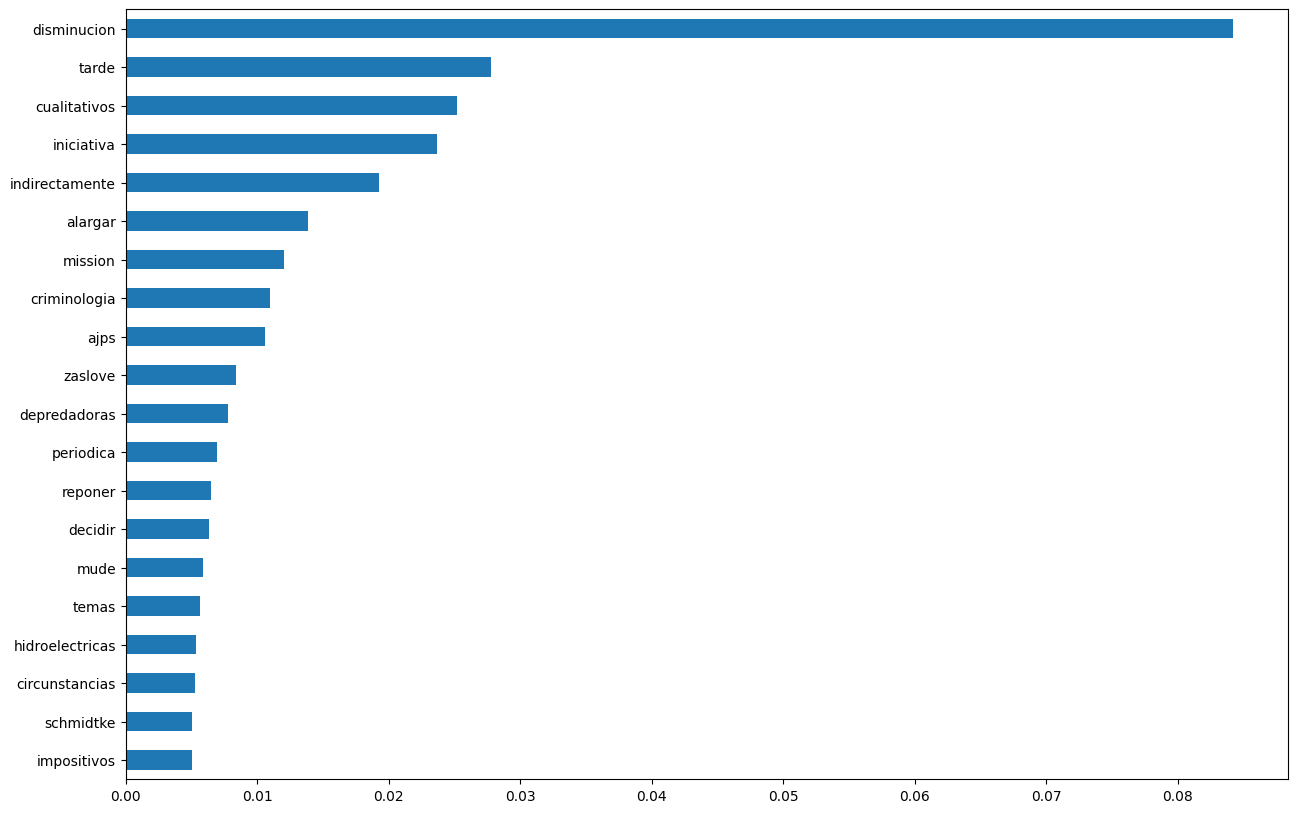

In [22]:
# Feature importance in tree models is an indicator on how relevant is a feature for taking the decision by the model
pd.Series(bow_model.feature_importances_, index=bow.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15, 10))

In [23]:
bow_estimators = bow_model.estimators_
print("Number of trees:", len(bow_estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in bow_estimators]))

Number of trees: 100
Trees depth (mean): 72.35


In [24]:
y_train_bow_predict = bow_model.predict(X_bow)
y_test_bow_predict = bow_model.predict(bow.transform(X_test["Textos_espanol"]))

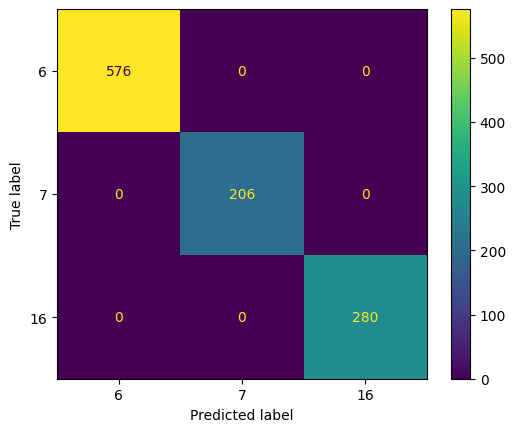

In [25]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

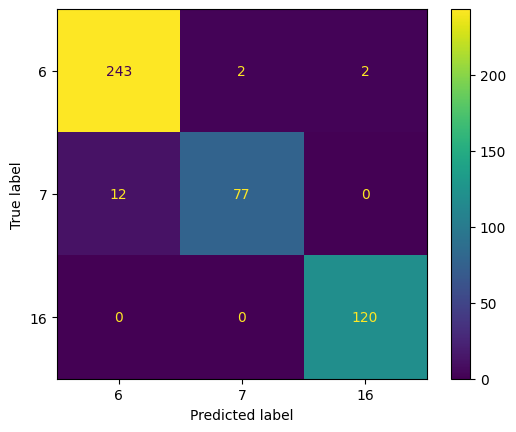

In [26]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [27]:
print(PRECISION, precision_score(y_train, y_train_bow_predict, average="weighted"))
print(RECALL, recall_score(y_train, y_train_bow_predict, average="weighted"))
print(F1, f1_score(y_train, y_train_bow_predict, average="weighted"))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [28]:
print(PRECISION, precision_score(y_test, y_test_bow_predict, average="weighted"))
print(RECALL, recall_score(y_test, y_test_bow_predict, average="weighted"))
print(F1, f1_score(y_test, y_test_bow_predict, average="weighted"))

Precision: 0.9652545897292087
Recall: 0.9649122807017544
F1: 0.9642962452543506


### Model selection

In [29]:
pipeline = Pipeline(steps = [
    ("vectorizer", CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)),
    ("classifier", RandomForestClassifier(random_state=4)),
])

In [30]:
param_grid = {
    "vectorizer": [CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words), TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words)],
    "vectorizer__lowercase": [True, False],
    "classifier__n_estimators": [50, 100],
    "classifier__criterion": ['gini', 'entropy'],
    "classifier__max_depth": [25, 50, 75, 100], 
}


In [31]:
search = RandomizedSearchCV(pipeline, param_grid, n_iter=10, scoring=["precision", "recall", "f1"], refit="f1", cv=7, return_train_score=True, verbose=1, random_state=5)


In [32]:
search.fit(X_train["Textos_espanol"], y_train)

Fitting 7 folds for each of 10 candidates, totalling 70 fits


RandomizedSearchCV(cv=7,
                   estimator=Pipeline(steps=[('vectorizer',
                                              CountVectorizer(stop_words=['de',
                                                                          'la',
                                                                          'que',
                                                                          'el',
                                                                          'en',
                                                                          'y',
                                                                          'a',
                                                                          'los',
                                                                          'del',
                                                                          'se',
                                                                          'las',
                                                                          'por',
                                                                          'un',
                                                                          'para',
                                                                          'con',
                                                                          'no',
                                                                          'una',
                                                                          'su',
                                                                          'al',
                                                                          'lo',
                                                                          'como',
                                                                          'más',
                                                                          'pero',
                                                                          'sus',
                                                                          'le',
                                                                          'ya',
                                                                          'o',
                                                                          'este',
                                                                          'sí',
                                                                          'porque', ...],
                                                              tokenizer=<function word_tokenize at 0x7f67393dd580>)),
                                             ('classifier',
                                              RandomForestClassif...
                                                                                   'la',
                                                                                   'que',
                                                                                   'el',
                                                                                   'en',
                                                                                   'y',
                                                                                   'a',
                                                                                   'los',
                                                                                   'del',
                                                                                   'se',
                                                                                   'las',
                                                                                   'por',
                                                                                   'un',
                                                                                   'para',
                                                                                  

In [33]:
search.best_params_

{'vectorizer__lowercase': False,
 'vectorizer': CountVectorizer(stop_words=['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los',
                             'del', 'se', 'las', 'por', 'un', 'para', 'con',
                             'no', 'una', 'su', 'al', 'lo', 'como', 'más',
                             'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí',
                             'porque', ...],
                 tokenizer=<function word_tokenize at 0x7f67393dd580>),
 'classifier__n_estimators': 100,
 'classifier__max_depth': 100,
 'classifier__criterion': 'gini'}

In [34]:
search.best_score_

nan

In [35]:
y_train_search_predict = search.best_estimator_.predict(X_train["Textos_espanol"])
y_test_search_predict = search.best_estimator_.predict(X_test["Textos_espanol"])


In [36]:
print(PRECISION, precision_score(y_train, y_train_search_predict, average="weighted"))
print(RECALL, recall_score(y_train, y_train_search_predict, average="weighted"))
print(F1, f1_score(y_train, y_train_search_predict, average="weighted"))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [37]:
print(PRECISION, precision_score(y_test, y_test_search_predict, average="weighted"))
print(RECALL, recall_score(y_test, y_test_search_predict, average="weighted"))
print(F1, f1_score(y_test, y_test_search_predict, average="weighted"))

Precision: 0.9632026219707408
Recall: 0.9627192982456141
F1: 0.9621527299887555


# Predicción y guardado de data

In [38]:
ods_df_unlabeled = pd.read_csv("../data/SinEtiquetatest_cat_6716.csv")
#Predict the labels of the unlabeled data
y_unlabeled_predict = search.best_estimator_.predict(ods_df_unlabeled["Textos_espanol"])
#Add the predicted labels to the unlabeled data
ods_df_unlabeled["sdg"] = y_unlabeled_predict
#Save the labeled data
ods_df_unlabeled.to_csv("../data/Predicted.csv", index=False)
